In [1]:
import os
from pathlib import Path
import IPython.display as ipd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import plotly.graph_objs as go
import plotly.offline as py
from IPython import display
import time
from datetime import datetime
import tensorflow as tf
import seaborn as sns
import tensorflow_hub as hub
import subprocess
from subprocess import check_output
import threading
from multiprocessing import Queue
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

# NOTES
NOTES = "mobilenetv2-128"

# VARS
target_label = "label"
id_label = "fname"
OUTSTR = "A{:.4f}_Type{}_LR{}_S{}_B{}{}.csv"
VERBOSE = True
DISPLAY = True
TEST = False
TPU = False
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
CHANNELS = 3
TYPE = "TL"
DEFAULT_BS = 128 # default batch size
UNK_DROP_RATE = 0.9 # drop 90% of unknown categories
MODULE = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/classification/2"

if TEST:
    LEARNING_STEPS = 200
    LEARNING_RATE = 0.005
    BATCH_SIZE = 64
    VERBOSITY = 1000
    TEST_SIZE = 5000
    SHUFFLE_SIZE = 64
else:
    LEARNING_STEPS = 20000
    LEARNING_RATE = 0.0025
    BATCH_SIZE = 64
    VERBOSITY = 1000
    SHUFFLE_SIZE = 64

# PATHS
paths = {
    "Kaggle":"/home/wesleytocs/.kaggle/competitions/tensorflow-speech-recognition-challenge/",
    "Training":"/home/wesleytocs/.kaggle/competitions/tensorflow-speech-recognition-challenge/train/audio",
    "Images":"/home/wesleytocs/Speech/images/",
    "TrainImg":"/home/wesleytocs/Speech/images/train",
    "TestImg":"/home/wesleytocs/Speech/images/test",
    "Testing":"/home/wesleytocs/.kaggle/competitions/tensorflow-speech-recognition-challenge/test/audio",
    "Submission":"/home/wesleytocs/.kaggle/competitions/tensorflow-speech-recognition-challenge/sample_submission.csv",
    "Model":"/home/wesleytocs/Speech/model_dir/",
    "Logs":"/home/wesleytocs/Speech/logs/{}/".format(datetime.strftime(datetime.now(), "%b%d%Y_%H%M%S"))
}
paths["Log"] = paths["Logs"] + "log.txt"
if not os.path.isdir(paths["Logs"]):
    os.mkdir(paths["Logs"])
if not os.path.isdir(paths["Images"]):
    os.mkdir(paths["Images"])
if not os.path.isdir(paths["TrainImg"]):
    os.mkdir(paths["TrainImg"])
if not os.path.isdir(paths["TestImg"]):
    os.mkdir(paths["TestImg"])

In [2]:
def make_header(s):
    return ("#" * 42) + ("\n{:^42}\n".format(s)) + ("#" * 42)
    
def print_and_log(s):
    with open(paths["Log"], 'a') as log:
        log.write(str(s))
        log.write("\n")
    print(s)
        
def print_and_log_header(s):
    h = make_header(str(s))
    with open(paths["Log"], 'a') as log:
        log.write(h)
        log.write("\n")
    print(h)

In [3]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def sec_to_str(secs):
    ms = secs - int(secs)
    days = int(secs // (24 * 3600))
    hours = int((secs % ((24 * 3600))) // 3600)
    minutes = int((secs % 3600) // 60)
    seconds = int(secs % 60)
    return "{:02}:{:02}:{:02}:{:02}.{}".format(days, hours, minutes, seconds, "{:.3}".format(ms)[2:])

def timer(f, *args):
    print_and_log("Start: {}".format(datetime.now()))
    start = time.time()
    result = f(*args)
    end = time.time()
    print_and_log("End: {}".format(datetime.now()))
    print_and_log("Finished in {}".format(sec_to_str(end - start)))
    return result

def spec_display(sample_rate, samples, freqs, times, spectrogram):
    fig = plt.figure(figsize=(14, 14))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + filename)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
    ax2 = fig.add_subplot(212)
    ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax2.set_yticks(freqs[::16])
    ax2.set_xticks(times[::16])
    ax2.set_title('Spectrogram of ' + filename)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')

In [4]:
def make_images_from_wav(data_path, image_path, overwrite=False, useLabels=True):
    lbls = labels
    if not useLabels:
        lbls = [""]
    LABELS = []
    PATHS = []
    items = 0
    found = 0
    created = 0
    for label in lbls:
        label_path = os.path.join(image_path, label)
        print_and_log("\tProcessing: {}".format(label_path))
        if not os.path.isdir(label_path):
            os.mkdir(label_path)
        for file in [item for item in os.listdir(os.path.join(data_path, label)) if item.endswith(".wav")]:
            items += 1
            wavpath = os.path.join(data_path, label, file)
            imgpath = os.path.join(label_path, file[:-4] + ".png")
            if overwrite or not os.path.isfile(imgpath):
                created += 1
                command = ["sox", wavpath, "-n", "spectrogram", "-x", str(TARGET_WIDTH), "-y", str(TARGET_HEIGHT), "-r", "-o", imgpath]
                subprocess.run(command) # multithread? CPU underutilized here
                if VERBOSE and items % VERBOSITY == 0:
                    print_and_log("\t            Created {}th .png file".format(items))
            else:
                found += 1
                if VERBOSE and items % VERBOSITY == 0:
                    print_and_log("\t            Found {}th .png file".format(items))
            if useLabels:
                LABELS.append(lbls[label])
            PATHS.append(imgpath)
    print_and_log("\tFound:\t\t{}\n\tCreated:\t{}".format(found, created))
    if useLabels:
        df = pd.DataFrame({target_label:LABELS, "Path":PATHS})
    else:
        df = pd.DataFrame({"Path":PATHS})
    return df

In [5]:
count = 0
def _parse_function(filename, label):
    global count
    count += 1
    if count % VERBOSITY == 0:
        print_and_log("\tProcessed {}th image".format(count))
    expected_shape = tf.constant([1, TARGET_HEIGHT, TARGET_WIDTH, CHANNELS])
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_image(image_string, channels=CHANNELS)
    image_decoded = tf.image.convert_image_dtype(image_decoded, tf.float32)
    image_decoded = tf.reshape(image_decoded, expected_shape)
    return image_decoded, label

In [6]:
def mobilenet_model_fn(features, labels, mode):
    # Load mobilenet-v2 model.
    global num_label
    module = hub.Module(MODULE)
    features = tf.squeeze(features)
    outputs = module(features)

    logits = tf.layers.dense(inputs=outputs, units=num_labels)

    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if not TPU:
        tf.summary.histogram("predictions", predictions["probabilities"])
        tf.summary.histogram("classes", predictions["classes"])

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    predictions["loss"] = loss

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
        if TPU:
            optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [7]:
def create_training_input_fn(dataset, batch_size, num_epochs=None):
    def _input_fn(num_epochs=None, shuffle=True):
        ds = dataset.batch(batch_size).repeat(num_epochs)
        if shuffle:
            ds = ds.shuffle(SHUFFLE_SIZE)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def create_predict_input_fn(dataset, batch_size):
    def _input_fn():
        ds = dataset.batch(batch_size)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def train():
    periods = LEARNING_STEPS // 1000
    steps_per_period = LEARNING_STEPS // periods
    t_accs = []
    v_accs = []
    t_lls = []
    v_lls = []
    print_and_log("Training model...\nMetrics:")
    print_and_log("\tPERIOD\tTYPE\tTRAIN.\tVALID.")
    for period in range(periods):
        classifier.train(
            input_fn=train_input_fn,
            steps=steps_per_period)
        training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
        validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
        t_ll = training_stats["loss"]
        t_acc = 100 * training_stats["accuracy"]
        v_ll = validation_stats["loss"]
        v_acc = 100 * validation_stats["accuracy"]
        print_and_log("\t{}\tLgLs\t{:.2f}\t{:.2f}".format(period, t_ll, v_ll))
        print_and_log("\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
        t_lls.append(t_ll);
        v_lls.append(v_ll)
        t_accs.append(t_acc)
        v_accs.append(v_acc)
    accuracy = classifier.evaluate(input_fn=validation_eval_input_fn)["accuracy"] * 100
    return classifier, accuracy, t_lls, v_lls, t_accs, v_accs

In [8]:
with open(paths["Log"], 'w') as log:
    log.write(make_header("Starting Script\n"))
    
if VERBOSE:
    print(check_output(["ls", paths["Kaggle"]]).decode("utf8"))
    print(os.listdir(paths["Training"]))

link_to_gcp_credits_form.txt
sample_submission.csv
test
train

['tree', 'five', 'dog', 'happy', 'go', 'right', '_background_noise_', 'marvin', 'no', 'eight', 'one', 'bed', 'bird', 'nine', 'wow', 'two', 'on', 'stop', 'house', 'left', 'silence', 'seven', 'three', 'sheila', 'zero', 'cat', 'four', 'off', 'yes', 'down', 'up', 'six']


In [9]:
# Create variables for the paths
train_audio_path = paths["Training"]
test_audio_path = paths["Testing"]
train_image_path = paths["TrainImg"]
test_image_path = paths["TestImg"]

# Store the labels to train
labels = ['tree', 'five', 'dog', 'happy', 'go', 'right',
          'marvin', 'no', 'eight', 'one', 'bed', 'bird',
          'nine', 'wow', 'two', 'on', 'stop', 'house', 'left',
          'silence', 'seven', 'three', 'sheila', 'zero', 'cat',
          'four', 'off', 'yes', 'down', 'up', 'six']
num_labels = len(labels)
labels = {x[1]:x[0] for x in enumerate(labels)}
labels_ = {labels[k]:k for k in labels}

# Place all the unwanted labels into an unknown category
reverse_lookup = dict() #reverse the labels dictionary to re-map numbers to their original string labels 
allowed_labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence"]
allowed_labels_ = [labels[label] for label in allowed_labels]
drop_labels = [labels[l] for l in list(set(labels.keys()) - set(allowed_labels))]
for label in labels:
    if label not in allowed_labels:
        reverse_lookup[labels[label]] = "unknown"
    else:
        reverse_lookup[labels[label]] = label

In [10]:
# Make the training data
print_and_log_header("MAKING TRAINING DATA")
train_data = timer(make_images_from_wav, train_audio_path, train_image_path)
train_data = train_data.reindex(np.random.permutation(train_data.index))
if VERBOSE:
    print_and_log_header("TRAIN DATA")
    print_and_log(train_data.describe())
    print_and_log(train_data.head(10))

##########################################
           MAKING TRAINING DATA           
##########################################
Start: 2018-07-14 22:48:22.754889
	Processing: /home/wesleytocs/Speech/images/train/one
	            Found 1000th .png file
	            Found 2000th .png file
	Processing: /home/wesleytocs/Speech/images/train/bird
	            Found 3000th .png file
	            Found 4000th .png file
	Processing: /home/wesleytocs/Speech/images/train/go
	            Found 5000th .png file
	            Found 6000th .png file
	Processing: /home/wesleytocs/Speech/images/train/bed
	            Found 7000th .png file
	            Found 8000th .png file
	Processing: /home/wesleytocs/Speech/images/train/house
	            Found 9000th .png file
	Processing: /home/wesleytocs/Speech/images/train/yes
	            Found 10000th .png file
	            Found 11000th .png file
	            Found 12000th .png file
	Processing: /home/wesleytocs/Speech/images/train/right
	            Found 1

In [11]:
print_and_log_header("MAKING TEST DATA")
test_data = timer(make_images_from_wav, test_audio_path, test_image_path, False, False)
test_data = test_data.reindex(np.random.permutation(test_data.index))
if VERBOSE:
    print_and_log_header("TEST DATA")
    print_and_log(test_data.describe())
    print_and_log(test_data.head(10))

##########################################
             MAKING TEST DATA             
##########################################
Start: 2018-07-14 22:48:26.003481
	Processing: /home/wesleytocs/Speech/images/test/
	            Found 1000th .png file
	            Found 2000th .png file
	            Found 3000th .png file
	            Found 4000th .png file
	            Found 5000th .png file
	            Found 6000th .png file
	            Found 7000th .png file
	            Found 8000th .png file
	            Found 9000th .png file
	            Found 10000th .png file
	            Found 11000th .png file
	            Found 12000th .png file
	            Found 13000th .png file
	            Found 14000th .png file
	            Found 15000th .png file
	            Found 16000th .png file
	            Found 17000th .png file
	            Found 18000th .png file
	            Found 19000th .png file
	            Found 20000th .png file
	            Found 21000th .png file
	            Found 

In [12]:
ids = pd.Series([os.path.basename(x)[:-4]+".wav" for x in test_data["Path"]]) # store the wav filenames for output
if VERBOSE:
    print_and_log_header("IDS")
    print_and_log(ids.describe())
    print_and_log(ids.head(10))

##########################################
                   IDS                    
##########################################
count                 158538
unique                158538
top       clip_449181ba6.wav
freq                       1
dtype: object
0    clip_b80e15ca3.wav
1    clip_cfb1b5ced.wav
2    clip_39c123283.wav
3    clip_0033ccb72.wav
4    clip_5f1aed6fb.wav
5    clip_90d3db7c8.wav
6    clip_b9269d23d.wav
7    clip_505882a79.wav
8    clip_f3272a454.wav
9    clip_810471f19.wav
dtype: object


In [13]:
# filter out non-allowed labels
print_and_log_header("FILTERING OUT NON-ALLOWED LABELS")
for dlabel in drop_labels:
    train_data.drop(train_data[train_data[target_label] == dlabel].sample(frac=UNK_DROP_RATE).index, inplace=True)
    print_and_log("Dropping {:.2f}% of label {:02} - {}".format(UNK_DROP_RATE * 100, dlabel, labels_[dlabel]))

##########################################
     FILTERING OUT NON-ALLOWED LABELS     
##########################################
Dropping 90.00% of label 06 - marvin
Dropping 90.00% of label 13 - wow
Dropping 90.00% of label 09 - one
Dropping 90.00% of label 11 - bird
Dropping 90.00% of label 10 - bed
Dropping 90.00% of label 12 - nine
Dropping 90.00% of label 21 - three
Dropping 90.00% of label 17 - house
Dropping 90.00% of label 25 - four
Dropping 90.00% of label 20 - seven
Dropping 90.00% of label 22 - sheila
Dropping 90.00% of label 03 - happy
Dropping 90.00% of label 08 - eight
Dropping 90.00% of label 01 - five
Dropping 90.00% of label 02 - dog
Dropping 90.00% of label 24 - cat
Dropping 90.00% of label 00 - tree
Dropping 90.00% of label 23 - zero
Dropping 90.00% of label 14 - two
Dropping 90.00% of label 30 - six


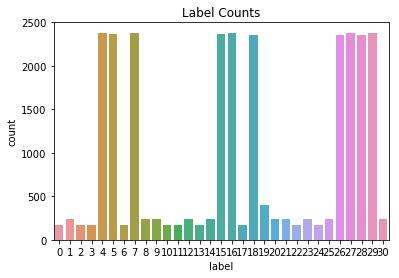

In [14]:
if DISPLAY:
    ax = sns.countplot(x=target_label, data=train_data)
    ax.set_title("Label Counts")
    ax.get_figure().savefig(paths["Logs"] + "target_counts.jpg")

In [15]:
# Make the label set
train_labels = train_data.pop(target_label)

# 80/20 training/validation split
t_size = int(0.8 * train_data.shape[0])
validation_data = train_data[t_size:]
validation_labels = train_labels[t_size:]
train_data = train_data[:t_size]
train_labels = train_labels[:t_size]
test_labels = pd.Series([labels["yes"] for _ in range(test_data.shape[0])], dtype=np.int32)

train_data = train_data["Path"]
validation_data = validation_data["Path"]
test_data = test_data["Path"]

In [16]:
# Sanity check on data
print_and_log_header("TRAINING")
print_and_log(train_data.shape)
print_and_log(type(train_data))
print_and_log(train_labels.shape)
print_and_log(type(train_labels))
print_and_log_header("VALIDATION")
print_and_log(validation_data.shape)
print_and_log(type(validation_data))
print_and_log(validation_labels.shape)
print_and_log(type(validation_labels))
print_and_log_header("TESTING")
print_and_log(test_data.shape)
print_and_log(type(test_data))
print_and_log(test_labels.shape)
print_and_log(type(test_labels))
print_and_log(set(test_labels))

##########################################
                 TRAINING                 
##########################################
(22550,)
<class 'pandas.core.series.Series'>
(22550,)
<class 'pandas.core.series.Series'>
##########################################
                VALIDATION                
##########################################
(5638,)
<class 'pandas.core.series.Series'>
(5638,)
<class 'pandas.core.series.Series'>
##########################################
                 TESTING                  
##########################################
(158538,)
<class 'pandas.core.series.Series'>
(158538,)
<class 'pandas.core.series.Series'>
{27}


In [17]:
# Grab subset of the data for testing purposes
if TEST:
    train_data = train_data[:TEST_SIZE]
    train_labels = train_labels[:TEST_SIZE]
    validation_data = validation_data[:TEST_SIZE]
    validation_labels = validation_labels[:TEST_SIZE]
    test_data = test_data[:TEST_SIZE]
    test_labels = test_labels[:TEST_SIZE]
    ids = ids[:TEST_SIZE]

In [18]:
# Vectors of filenames.
train_filenames = tf.constant(train_data)
validation_filenames = tf.constant(validation_data)
test_filenames = tf.constant(test_data)

# `labels[i]` is the label for the image in `filenames[i]
# Vectors of labels
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)
test_labels = tf.constant(test_labels)

# Make datasets from filenames and labels
train_data = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
validation_data = tf.data.Dataset.from_tensor_slices((validation_filenames, validation_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
print_and_log_header("Parsing Training Data")
train_data = timer(lambda: train_data.map(_parse_function))
print_and_log_header("Parsing Validation Data")
validation_data = timer(lambda: validation_data.map(_parse_function))
print_and_log_header("Parsing Testing Data")
test_data = timer(lambda: test_data.map(_parse_function))
print_and_log("\nDone!")

##########################################
          Parsing Training Data           
##########################################
Start: 2018-07-14 22:48:37.867894
End: 2018-07-14 22:48:37.995609
Finished in 00:00:00:00.128
##########################################
         Parsing Validation Data          
##########################################
Start: 2018-07-14 22:48:37.997387
End: 2018-07-14 22:48:38.054252
Finished in 00:00:00:00.0565
##########################################
           Parsing Testing Data           
##########################################
Start: 2018-07-14 22:48:38.055621
End: 2018-07-14 22:48:38.109887
Finished in 00:00:00:00.0541

Done!


In [19]:
print_and_log_header("TRAINING")
print_and_log(train_data)
print_and_log(type(train_data))
print_and_log_header("VALIDATION")
print_and_log(validation_data)
print_and_log(type(validation_data))
print_and_log_header("TESTING")
print_and_log(test_data)
print_and_log(type(test_data))

##########################################
                 TRAINING                 
##########################################
<MapDataset shapes: ((1, 128, 128, 3), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
##########################################
                VALIDATION                
##########################################
<MapDataset shapes: ((1, 128, 128, 3), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
##########################################
                 TESTING                  
##########################################
<MapDataset shapes: ((1, 128, 128, 3), ()), types: (tf.float32, tf.int32)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [20]:
# Create the Estimator
if TPU:
    classifier = tf.contrib.tpu.TPUEstimator(
        model_fn=mobilenet_model_fn,
        model_dir=paths["Model"],
        config=tf.contrib.tpu.RunConfig(),
        use_tpu=TPU)
else:
    classifier = tf.estimator.Estimator(model_fn=mobilenet_model_fn, model_dir=paths["Model"])

In [21]:
# Create the input functions.
training_eval_input_fn = create_predict_input_fn(train_data, DEFAULT_BS)
validation_eval_input_fn = create_predict_input_fn(validation_data, DEFAULT_BS)
train_input_fn = create_training_input_fn(train_data, BATCH_SIZE)

In [22]:
# Train
classifier, accuracy, t_lls, v_lls, t_accs, v_accs = timer(train)

Start: 2018-07-14 22:48:38.182702
Training model...
Metrics:
	PERIOD	TYPE	TRAIN.	VALID.
	0	LgLs	2.01	2.05
		Acc.	43.80%	43.69%

	1	LgLs	1.80	1.84
		Acc.	49.46%	48.37%

	2	LgLs	1.70	1.75
		Acc.	51.52%	50.69%

	3	LgLs	1.62	1.69
		Acc.	52.79%	51.84%

	4	LgLs	1.58	1.65
		Acc.	53.76%	52.70%

	5	LgLs	1.54	1.62
		Acc.	54.86%	54.13%

	6	LgLs	1.51	1.59
		Acc.	55.29%	53.42%

	7	LgLs	1.47	1.56
		Acc.	56.33%	54.59%

	8	LgLs	1.45	1.55
		Acc.	56.48%	54.90%

	9	LgLs	1.43	1.53
		Acc.	57.29%	55.16%

	10	LgLs	1.41	1.52
		Acc.	57.77%	55.80%

	11	LgLs	1.40	1.51
		Acc.	58.19%	55.76%

	12	LgLs	1.38	1.49
		Acc.	58.43%	56.07%

	13	LgLs	1.37	1.48
		Acc.	59.05%	56.37%

	14	LgLs	1.35	1.47
		Acc.	59.29%	56.95%

	15	LgLs	1.35	1.47
		Acc.	59.34%	56.83%

	16	LgLs	1.35	1.47
		Acc.	59.43%	57.11%

	17	LgLs	1.32	1.45
		Acc.	59.93%	56.95%

	18	LgLs	1.32	1.45
		Acc.	60.15%	57.38%

	19	LgLs	1.31	1.45
		Acc.	60.31%	57.43%

End: 2018-07-15 04:08:31.105641
Finished in 00:05:19:52.923


Final accuracy (on validation data): 57.4317%


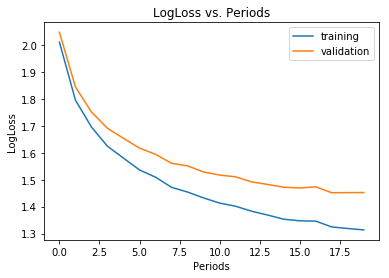

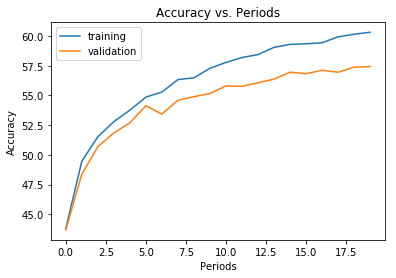

In [23]:
print_and_log("Final accuracy (on validation data): {:.4f}%".format(accuracy))

# Output a graph of loss metrics over periods.
if DISPLAY:
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(t_lls, label="training")
    plt.plot(v_lls, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["Logs"] + "loss.jpg")

# Output a graph of accuracy over periods.
if DISPLAY:
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.plot(t_accs, label="training")
    plt.plot(v_accs, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["Logs"] + "accuracy.jpg")

In [24]:
# Evaluate the model and print results (optional, only useful when there's a metric to compare against)
test_input_fn = create_predict_input_fn(test_data, DEFAULT_BS)
stats = classifier.evaluate(input_fn=test_input_fn)

In [25]:
if VERBOSE:
    t_accuracy = 100 * stats["accuracy"]
    print_and_log("Accuracy on evaluation data (expected ~{:.2f}%): {:.2f}%".format(100 / num_labels, t_accuracy))

Accuracy on evaluation data (expected ~3.23%): 4.93%


In [26]:
# Make Predictions
predictions = np.array([item['classes'] for item in classifier.predict(input_fn=test_input_fn)])
predictions = [reverse_lookup[x] for x in predictions]

In [27]:
# Make the output Dataframe
output = pd.DataFrame({id_label:ids, target_label:predictions})
print_and_log(output)

                     fname    label
0       clip_b80e15ca3.wav  unknown
1       clip_cfb1b5ced.wav      off
2       clip_39c123283.wav  unknown
3       clip_0033ccb72.wav       up
4       clip_5f1aed6fb.wav       up
5       clip_90d3db7c8.wav       on
6       clip_b9269d23d.wav    right
7       clip_505882a79.wav       on
8       clip_f3272a454.wav     down
9       clip_810471f19.wav       go
10      clip_7c0072e27.wav       no
11      clip_43c879f17.wav       go
12      clip_30049da53.wav     down
13      clip_4d4628df6.wav       go
14      clip_bc47fd9bd.wav     down
15      clip_ef602b89e.wav  silence
16      clip_f2f010d68.wav       no
17      clip_e777db854.wav       go
18      clip_65328e18d.wav     down
19      clip_0d969ba73.wav      off
20      clip_ea677517f.wav    right
21      clip_adc42556b.wav       on
22      clip_449ec1605.wav  unknown
23      clip_fd81d74cb.wav      yes
24      clip_3e0d1361f.wav       go
25      clip_b526a3986.wav      yes
26      clip_422f7787f.wav  

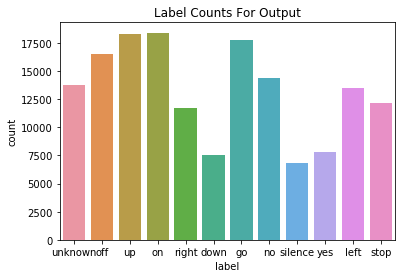

In [28]:
if DISPLAY:
    ax = sns.countplot(x=target_label, data=output)
    ax.set_title("Label Counts For Output")
    ax.get_figure().savefig(paths["Logs"] + "output_counts.jpg")

In [29]:
name = OUTSTR.format(accuracy, TYPE, LEARNING_RATE, LEARNING_STEPS, BATCH_SIZE,"_" + NOTES if NOTES else "")
print_and_log("Filename: '{}'".format(name))
if not TEST:
    output.to_csv(name, index=False)
    print_and_log("Saved to {}".format(name))

Filename: 'A57.4317_TypeTL_LR0.0025_S20000_B64_mobilenetv2-128.csv'
Saved to A57.4317_TypeTL_LR0.0025_S20000_B64_mobilenetv2-128.csv
